# Checkpoint modifications

Checkpoint modifications can be made to include more outputs or change certain aspects of the simulations (e.g., changing filters). Here, we demonstrate how to add an output for surface pressure and how to fix (make constant) the global mean log surface pressure. We found that the global mean surface pressure tends to drift in long integrations when using NeuralGCM, leading to less stable simulations. Fixing the global mean surface pressure increases stability in long integrations. The current reason for the drift in global mean surface pressure in long integrations is likely due to our dynamical core (and not the machine learning component), as we verified that using the dynamical core with orography also results in a drift in the global mean log surface pressure.

Steps:
1. Change the checkpoint to include surface pressure as an output variable and enforce a constant global mean log surface pressure.
2. Run the model and verify that the global mean log surface pressure is kept constant.
3. Run the model without fixing the global mean log surface pressure.

- In this [issue](https://github.com/neuralgcm/neuralgcm/issues/12) we discuss to add a Precipitation minus Evaporation diagnostics

```{tip}
You can run this notebook yourself in [Google Colab](https://colab.research.google.com/github/neuralgcm/neuralgcm/blob/main/docs/checkpoint_modifications.ipynb). We recommend using a GPU or TPU runtime due to high memory and compute requirements.
```

In [ ]:
#if needed
!pip install git+https://github.com/neuralgcm/neuralgcm.git@main

In [ ]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

### Change checkpoint to include surface pressure as a variable as an output and enforce a constant  global mean log surface pressure


In [ ]:

model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)


new_inputs_to_units_mapping = {
  'u': 'meter / second',
  'v': 'meter / second',
  't': 'kelvin',
  'z': 'm**2 s**-2',
  'sim_time': 'dimensionless',
  'tracers': {'specific_humidity': 'dimensionless',
            'specific_cloud_liquid_water_content': 'dimensionless',
            'specific_cloud_ice_water_content': 'dimensionless',
    },
    'diagnostics': {'surface_pressure': 'kg / (meter s**2)'}
  }

new_model_config_str = '\n'.join([
        ckpt['model_config_str'],
        f'DimensionalLearnedPrimitiveToWeatherbenchDecoder.inputs_to_units_mapping = {new_inputs_to_units_mapping}',
        'DimensionalLearnedPrimitiveToWeatherbenchDecoder.diagnostics_module = @NodalModelDiagnosticsDecoder',
        #Adding a diagnostic of surface pressure. If there are other diagnostics modules (e.g., PrecipitationMinusEvaporationDiagnostics) they will be removed.
        'StochasticPhysicsParameterizationStep.diagnostics_module = @SurfacePressureDiagnostics',
        # Adding FixGlobalMeanFilter which fixes global mean log surface pressure.
        'dycore/SequentialStepFilter.filter_modules = (@dycore/ExponentialFilter,@stability/ExponentialFilter,@surface_pressure/FixGlobalMeanFilter)',
        ])
ckpt['model_config_str'] = new_model_config_str
model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

### Run model and verify that global mean log surface pressure is kept constant


In [ ]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

demo_start_time = '2020-02-14'
demo_end_time = '2020-02-16'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

In [ ]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

In [ ]:
inner_steps = 1  # save model outputs once every 24 hours
outer_steps = 30 * 1 // inner_steps  # total of 30 days
timedelta = np.timedelta64(24, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds_fix_lsp = model.data_to_xarray(predictions, times=times)

In [ ]:
#to spherical harmonic representation (the 0,0 component is the global mean):
log_sp_spherical_harmonics_fix_lsp = model.data_coords.horizontal.to_modal(predictions_ds_fix_lsp.surface_pressure.pipe(np.log))
log_sp_spherical_harmonics_fix_lsp[:,0,0] #Should be almost constant

Array([40.756054, 40.75604 , 40.75605 , 40.756035, 40.75604 , 40.756042,
       40.756042, 40.756042, 40.756035, 40.75603 , 40.756042, 40.75604 ,
       40.756042, 40.756035, 40.75604 , 40.756054, 40.75604 , 40.75605 ,
       40.756042, 40.756046, 40.756042, 40.756042, 40.75604 , 40.75605 ,
       40.75605 , 40.756046, 40.75604 , 40.756042, 40.756042, 40.756054],      dtype=float32)

### Run model without fixing the global mean log surface pressure
Example: without fixing global mean log surface pressure (still adding surface
pressure as an output variable)

In [ ]:

model_name = 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt2 = pickle.load(f)


new_inputs_to_units_mapping = {
  'u': 'meter / second',
  'v': 'meter / second',
  't': 'kelvin',
  'z': 'm**2 s**-2',
  'sim_time': 'dimensionless',
  'tracers': {'specific_humidity': 'dimensionless',
            'specific_cloud_liquid_water_content': 'dimensionless',
            'specific_cloud_ice_water_content': 'dimensionless',
    },
    'diagnostics': {'surface_pressure': 'kg / (meter s**2)'}
  }

new_model_config_str = '\n'.join([
        ckpt2['model_config_str'],
        f'DimensionalLearnedPrimitiveToWeatherbenchDecoder.inputs_to_units_mapping = {new_inputs_to_units_mapping}',
        'DimensionalLearnedPrimitiveToWeatherbenchDecoder.diagnostics_module = @NodalModelDiagnosticsDecoder',
        'StochasticPhysicsParameterizationStep.diagnostics_module = @SurfacePressureDiagnostics',
        ])
ckpt2['model_config_str'] = new_model_config_str
model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt2)

In [ ]:
inner_steps = 1  # save model outputs once every 24 hours
outer_steps = 30 * 1 // inner_steps  # total of 30 days
timedelta = np.timedelta64(24, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

In [ ]:
#to spherical harmonic representation (the 0,0 component is the global mean):
log_sp_spherical_harmonics = model.data_coords.horizontal.to_modal(predictions_ds.surface_pressure.pipe(np.log))
log_sp_spherical_harmonics[:,0,0]

Array([40.756054, 40.756104, 40.75608 , 40.75609 , 40.75613 , 40.75616 ,
       40.75618 , 40.75609 , 40.75605 , 40.75599 , 40.755817, 40.755783,
       40.755848, 40.75599 , 40.75605 , 40.755997, 40.75583 , 40.75577 ,
       40.75577 , 40.75577 , 40.755825, 40.755867, 40.755928, 40.75601 ,
       40.756073, 40.756096, 40.75613 , 40.75609 , 40.756104, 40.75614 ],      dtype=float32)

### Compare global mean log surface pressure
(The small changes in global mean log surface pressure when we fix it are likely to be numerical inaccuracies)

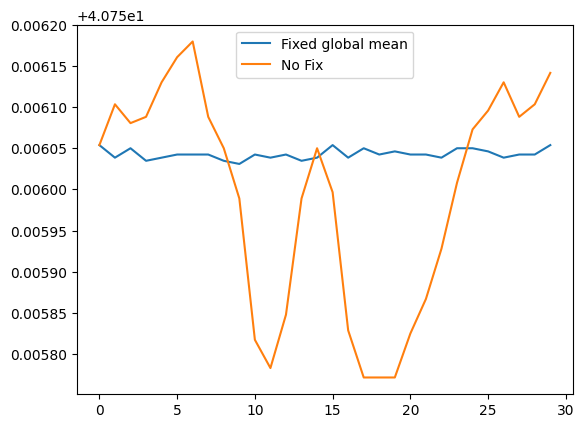

In [ ]:
import matplotlib.pyplot as plt
plt.plot(log_sp_spherical_harmonics_fix_lsp[:,0,0], label='Fixed global mean')
plt.plot(log_sp_spherical_harmonics[:,0,0], label='No Fix')
plt.legend()
plt.show()